<a href="https://colab.research.google.com/github/eeshahar/data-science/blob/main/EeshHariu3proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Average temperature during winter months in Seattle**
> I started this project by trying to search for top destinations in Europe selected and do a project related to average ticket prices. After searching for a long time, I wasn't able to find a dataset that seemed accurate, or one that had more than 50 entries. Eventually, I began to look into other things that I'm interested it; when I came across this dataset. I have always wanted to live in Seattle since I was young. I love the cold weather. This dataset had all months of the year and their temperatures, but I narrowed it down to only the winter months (November, December, January). The goal of this project is to estimate the average temperature in Seattle during the winter months.



In [ ]:
!pip install "preliz[full,notebook]"

In [2]:

import preliz as pz

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm

**Data:** The following section is to look and and try and determine what trends come with my data. The dataset that I used was

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Data science/Seattle_mean.csv')
temp = df['mean temp']
temp

,mean temp
0,30.5
1,54.5
2,36.0
3,24.0
4,44.5
...,...
650,57.0
651,62.5
652,70.5
653,74.5


The table above shows the mean temperatures for 655 months of winter in Seattle.

(array([  2.,  19.,  52., 135.,  91.,  83.,  61.,  84., 103.,  25.]),
 array([24.  , 29.35, 34.7 , 40.05, 45.4 , 50.75, 56.1 , 61.45, 66.8 ,
        72.15, 77.5 ]),
 <BarContainer object of 10 artists>)

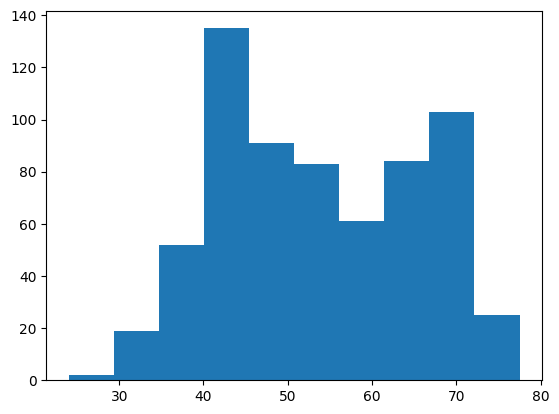

In [6]:
plt.hist(temp)

This histogram shows that most of the data is around the range of 45-55 degrees, which is leaning to be right skewed, but I'd say overall it has a distribution that is bimodal.

In [7]:
mean = temp.mean()
median = temp.median()
mode = temp.mode()
min = temp.min()
max = temp.max()
range = temp.max() - temp.min()

print (mean)
print (median)
print (mode)
print (min)
print (max)
print (range)


53.69770992366412
52.5
0    42.5
Name: mean temp, dtype: float64
24.0
77.5
53.5


Just to verify what I observed from the histogram, the mean of the data set is 53.7, the middle value (median) is 52.3, and the most occuring value (mode) is 42.5. The value of 53.7 is roughly in the middle (slightly higher) of 24.0 and 77.5, which are the minimum and maximum for this data set.

np.float64(50.75)

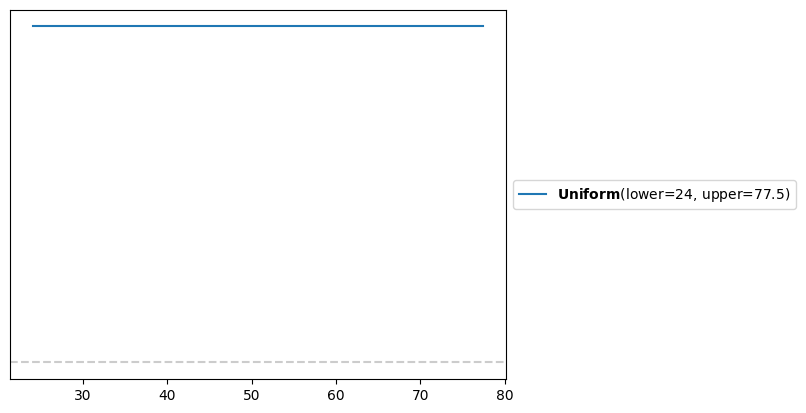

In [8]:
pz.Uniform(24,77.5).plot_pdf()
pz.Uniform(lower=24, upper=77.5).mean()

This is a uniform **prior**, which visualizes the mean. It's a Uniform distribution defined by a lower bound of 24 and an upper bound of 77.5.The graph illustrates that any value between 24 and 77.5 is equally likely, and the mean of this range is 50.75.

<Axes: >

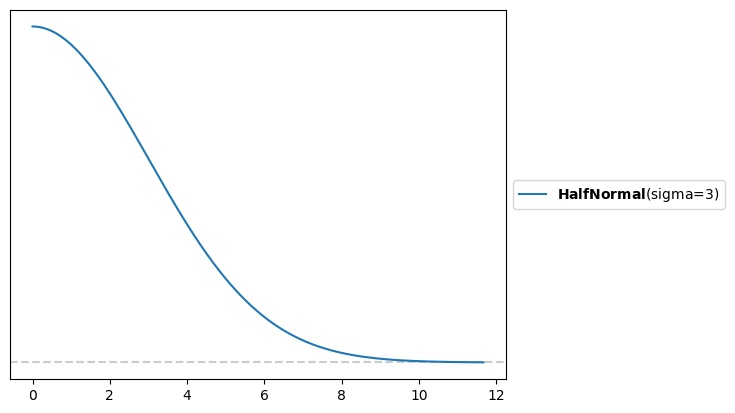

In [9]:
pz.HalfNormal(sigma = 3).plot_pdf()

This is a half normal distribution, which I found in the notes to represent the standard deviation prior.

In [ ]:
with pm.Model() as model_mean_temp:
    # mean prior, what we believed before
    μ = pm.Uniform('μ', lower = 24, upper = 77.5)

    # prior for the STD
    σ = pm.HalfCauchy('σ', beta = 0.3)

    # outliers prior
    ν = pm.Exponential('ν', 1/30)

    # studentT distribution likelihood
    y = pm.StudentT('y', mu = μ, sigma = σ, nu=ν, observed=temp)

    idata_mean_temp = pm.sample()

array([<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'ν'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

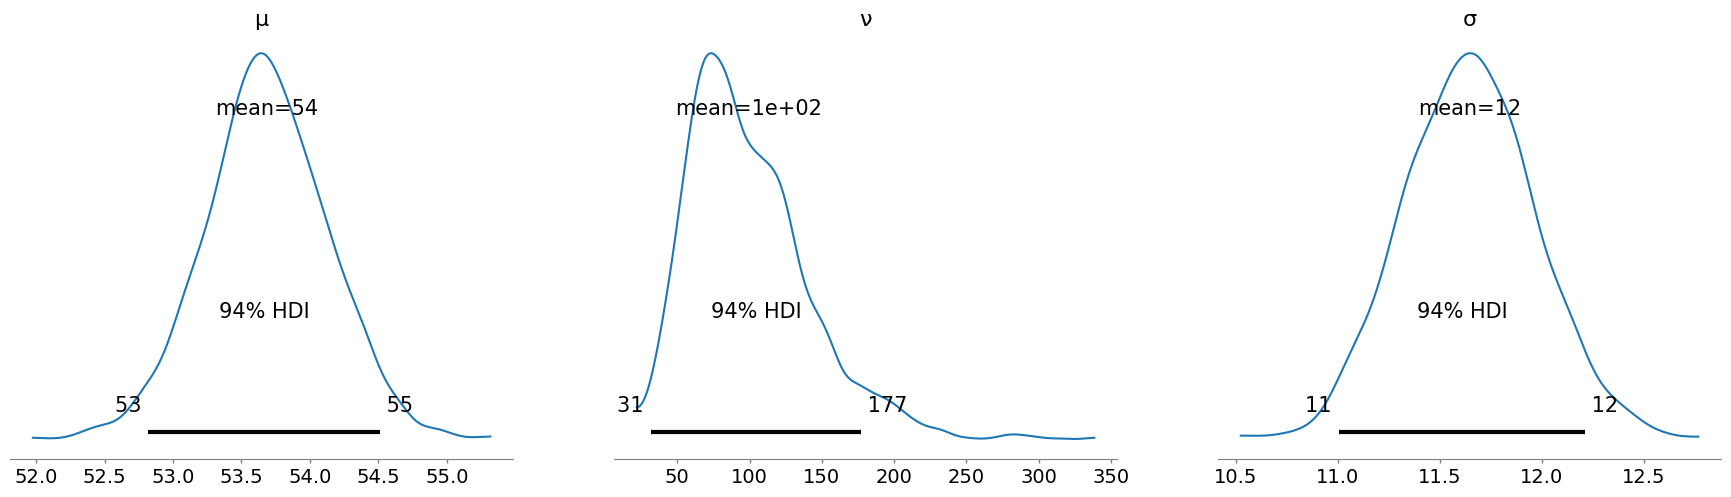

In [11]:
az.plot_posterior(idata_mean_temp)


1. Mu posterior distribution: the distrubution is centered around 54.
2. Nu posterior distribution: skewed with a tail to the right. Because of such a long tail, it implies that the data probably has more outliers than expected. But a mean of 98 means that the data is near a normal distribution, so the outliers aren't that extreme
3. Sigma posterior distribution: The estimated standard deviation is 12. This indicates a moderate amount of spread in the data, 12 degrees higher and lower than the average, 54

In [ ]:
pm.sample_posterior_predictive(idata_mean_temp, model=model_mean_temp, extend_inferencedata=True)

<Axes: xlabel='y'>

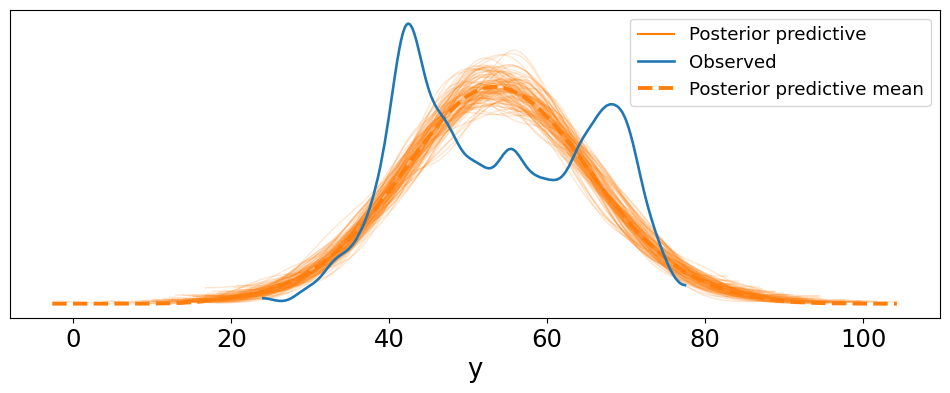

In [13]:
az.plot_ppc(idata_mean_temp, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])


To break down the model above, the blue line represeents the trend of the actual CSV mean temperature dataset. The numerous thin orange lines represent the 'simulated datasets' and it shows the distribution of possible data that the model thinks could be possible. The dashed orange one is just the mean of the thin orange lines.



  The posterior predictive does not match up with the observed, so I would say that the StudentT model doesn't work well for this data.

In [ ]:
#ST is for skew T
with pm.Model() as model_mean_temp:
    #same weak prior
    μ = pm.Uniform('μ', lower=22, upper=77.5)

    #same as before
    σ = pm.HalfNormal('σ', sigma=0.3)

    #when a is larger than b, the dist. is positively skewed
    a = pm.HalfNormal('a', sigma=5)
    b = pm.HalfNormal('b', sigma=4)

    #SkewStudentR, which is the same as a T, except with more unusually high
    #or unusually low values.
    y = pm.SkewStudentT('y',mu=μ, sigma=σ, a = a, b = b, observed=temp)
    idata_mean_temp = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_mean_temp, model=model_mean_temp, extend_inferencedata=True)

(20.0, 100.0)

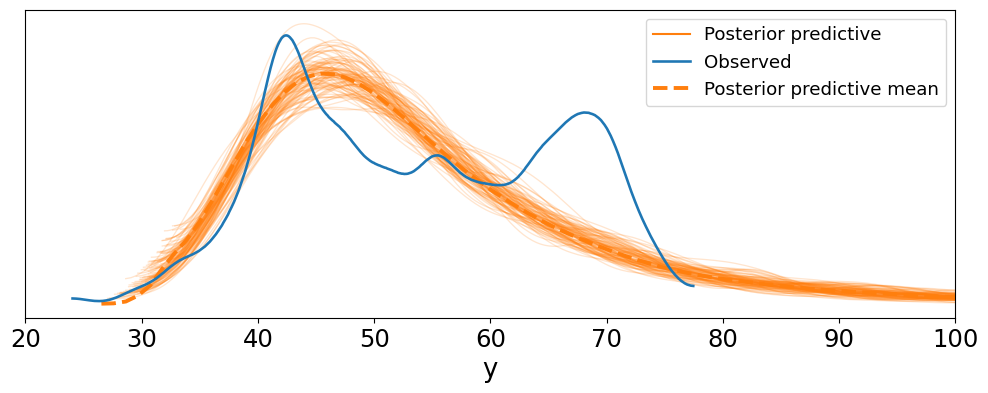

In [16]:
ax = az.plot_ppc(idata_mean_temp, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(20, 100)

Again, this model is doesn't work as well because there are two peaks.

(20.0, 60.0)

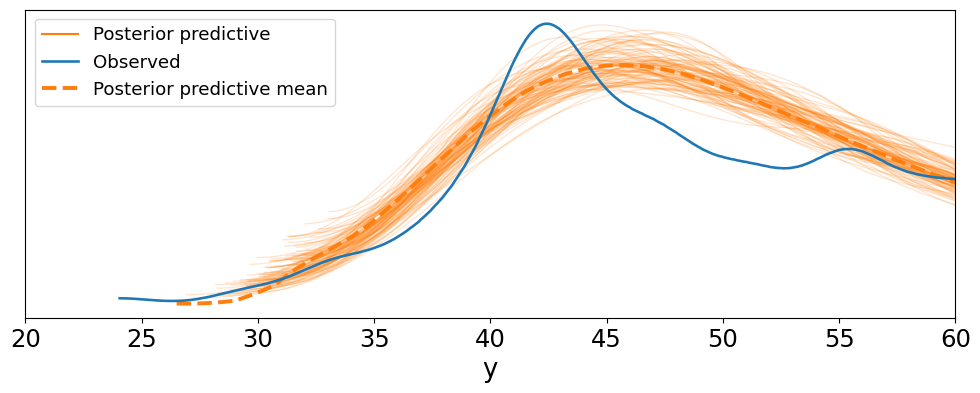

In [17]:
ax = az.plot_ppc(idata_mean_temp, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
#need to limit the x axis, so its more readable
ax.set_xlim(20, 60)

If we limit the temperatures to only be from 20 to 60 degrees, it's easier to get the model to fit correctly.